In [ ]:
!pip install numpy
!pip install nltk
!pip install pandas

In [ ]:
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
from os import getcwd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_string(s):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    s =re.sub(r'\$\w*', '', s)
    s = re.sub(r'^RT[\s]+', '', s)
    s = re.sub(r'https?:\/\/.*[\r\n]*', '', s)
    s = re.sub(r'#', '', s)
    tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
    s_tokens = tokenizer.tokenize(s)

    s_clean = []
    for word in s_tokens:
        if (word not in stopwords_english and
            word not in string.punctuation):
            stem_word = stemmer.stem(word)  # stemming word
            s_clean.append(stem_word)

    return s_clean

def build_freqs(list_text, list_sentiments):
    yslist = np.squeeze(list_sentiments).tolist()
    freqs = {}
    for y, s in zip(yslist, list_text):
        for word in process_string(s):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs


In [ ]:
import zipfile
with zipfile.ZipFile('dsaa-6100-movie-review-classification.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
df = pd.read_csv('movie_reviews/movie_reviews.csv')
df1= pd.read_csv('test_data.csv')
all_positive_s = df[df['label'] == 1]['text'].tolist()
all_negative_s = df[df['label'] == 0]['text'].tolist()
train_x = all_positive_s + all_negative_s



In [ ]:
test_x = df1['text'].tolist()

In [ ]:
test_x

In [ ]:
# combine positive and negative labels
train_y = np.append(np.ones((len(all_positive_s), 1)), np.zeros((len(all_negative_s), 1)), axis=0)

In [ ]:
freqs = build_freqs(train_x, train_y)
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))


type(freqs) = <class 'dict'>
len(freqs) = 143707


In [ ]:

def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)


    # calculate N_pos, N_neg, V_pos, V_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs.get((pair[0], 1.0), 0)

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs.get((pair[0], 0.0), 0)

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents
    D_pos = (train_y == 1).sum()

    # Calculate D_neg, the number of negative documents
    D_neg = (train_y == 0).sum()

    # Calculate logprior
    logprior = np.log(D_pos/D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1.0), 0)
        freq_neg = freqs.get((word, 0.0), 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(N_pos+V)
        p_w_neg = (freq_neg+1)/(N_neg+V)
        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    return logprior, loglikelihood

In [ ]:

logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

-0.004900009804118599
111272


In [ ]:
def naive_bayes_predict(s, logprior, loglikelihood):
    # process the string to get a list of words
    word_l = process_string(s)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [ ]:
s = 'He laughed.'
p = naive_bayes_predict(s, logprior, loglikelihood)
print('The expected output is', p)

The expected output is -0.28838436005760265


In [ ]:
for s in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    p = naive_bayes_predict(s, logprior, loglikelihood)
    print(f'{s} -> {p:.2f}')

I am happy -> 0.52
I am bad -> -1.39
this movie should have been great. -> 0.60
great -> 0.87
great great -> 1.75
great great great -> 2.63
great great great great -> 3.51


In [ ]:
s = 'you are bad :('
naive_bayes_predict(s, logprior, loglikelihood)

-1.3918087057530268

In [ ]:
import pandas as pd


# Tạo một danh sách để lưu trữ dự đoán
sentiments = []

for s in test_x:
    y_hat = naive_bayes_predict(s, logprior, loglikelihood)
    if y_hat >=0:
        sentiments.append(1)  # Positive sentiment
    else:
        sentiments.append(0)  # Negative sentiment




In [ ]:
df1['Category'] = sentiments

# Xóa trường 'text'
df1 = df1.drop(columns=['text'])

# Đổi tên các trường
df1 = df1.rename(columns={'id': 'Id'})

In [ ]:
df1

,Id,Category
0,0,0
1,1,1
2,2,0
3,3,1
4,4,1
...,...,...
9995,9995,1
9996,9996,0
9997,9997,1
9998,9998,1


In [ ]:
df1.to_csv('naive_bayes.csv', index=False)

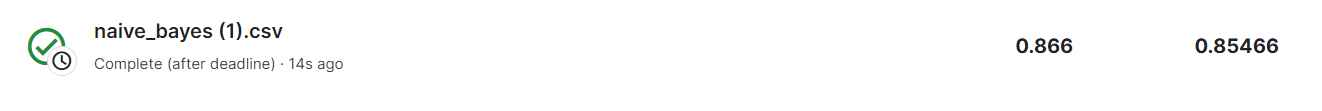

**Phân tích dữ liệu**

In [ ]:
import pandas as pd

def get_s_by_threshold(freqs, train_x, train_y):
    # Initialize an empty DataFrame
    df = pd.DataFrame(columns=['p_w_pos', 'p_w_neg', 'sentiment'])
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs.get((pair[0], 1.0), 0)

        # el-se, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs.get((pair[0], 0.0), 0)
    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents
    D_pos = (train_y == 1).sum()

    # Calculate D_neg, the number of negative documents
    D_neg = (train_y == 0).sum()

    # Calculate logprior
    logprior = np.log(D_pos/D_neg)
    for x,y in zip(train_x,train_y):
      word_l = process_string(x)
      freq_pos=freq_neg=0
      a=b=0
      for word in word_l:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1.0), 0)
        freq_neg = freqs.get((word, 0.0), 0)
        p_w_pos = np.log((freq_pos+1)/(N_pos+V))
        p_w_neg = np.log((freq_neg+1)/(N_neg+V))
        a=a+p_w_pos
        b=b+p_w_neg
      a=a+np.log(D_pos/D)
      b=b+np.log(D_neg/D)
      df = df.append({'p_w_pos': a, 'p_w_neg': b, 'sentiment': y},ignore_index=True)
    return df


In [ ]:
x = get_s_by_threshold(freqs, train_x, train_y)

In [ ]:
data=x
data

,p_w_pos,p_w_neg,sentiment
0,-480.629424,-474.873483,1
1,-310.324194,-309.599434,1
2,-598.829698,-593.233241,1
3,-129.295313,-131.544792,1
4,-223.775118,-225.014340,1
...,...,...,...
39995,-776.782084,-766.260852,0
39996,-1059.275082,-1042.153756,0
39997,-754.998118,-724.962636,0
39998,-2020.497460,-2005.834503,0


In [ ]:
import pandas as pd # Dataframe library

import matplotlib.pyplot as plt # Library for plots

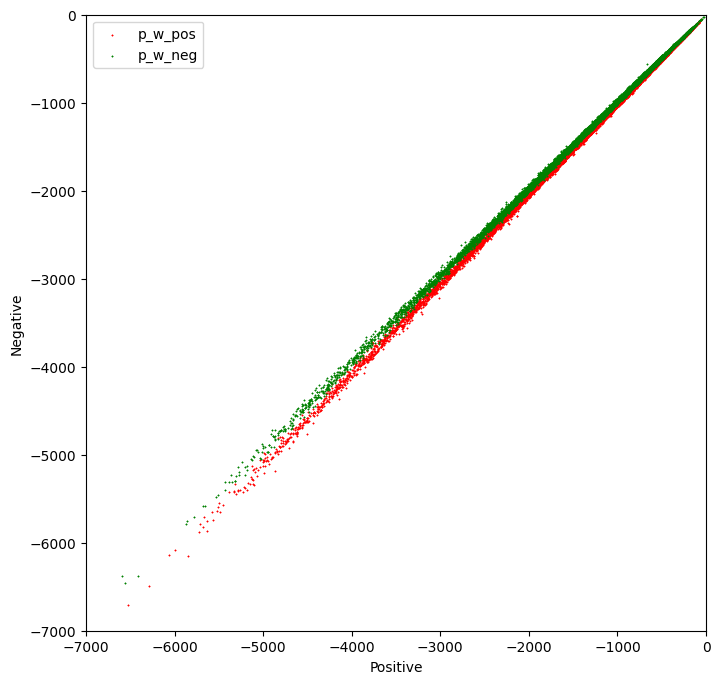

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (8, 8))

colors = ['green', 'red']
sentiments = ['p_w_neg', 'p_w_pos']

index = data.index

for sentiment in data.sentiment.unique():
    ix = index[data.sentiment == sentiment]
    ax.scatter(data.iloc[ix].p_w_pos, data.iloc[ix].p_w_neg, c=colors[int(sentiment)], s=0.1, marker='*', label=sentiments[int(sentiment)])

ax.legend(loc='best')

plt.xlim(-7000,0)
plt.ylim(-7000,0)

plt.xlabel("Positive")
plt.ylabel("Negative")
plt.show()
